In [5]:
from cmp import *
% matplotlib notebook
np.set_printoptions(threshold=np.nan)

Returning the following lattice and basis
[[ 0.5       -0.8660254  0.       ]
 [ 0.5        0.8660254  0.       ]
 [ 0.         0.         1.5      ]]
[[ 0.          0.          0.        ]
 [ 0.         -0.57735027  0.75      ]
 [ 0.          0.          0.5625    ]
 [ 0.         -0.57735027  1.3125    ]]
Before:
[ 0.5       -0.8660254  0.       ]
[0.5       0.8660254 0.       ]
[0.  0.  1.5]
[[ 0.          0.          0.        ]
 [ 0.         -0.57735027  0.75      ]
 [ 0.          0.          0.5625    ]
 [ 0.         -0.57735027  1.3125    ]]
orthogonality
False True True
after
[1. 0. 0.]
[-0.5        0.8660254  0.       ]
[0.  0.  1.5]
[[ 0.          0.          0.        ]
 [ 0.5        -0.28867513  0.75      ]
 [ 0.          0.          0.5625    ]
 [ 0.5        -0.28867513  1.3125    ]]
Lattice: simple monoclinic


<IPython.core.display.Javascript object>


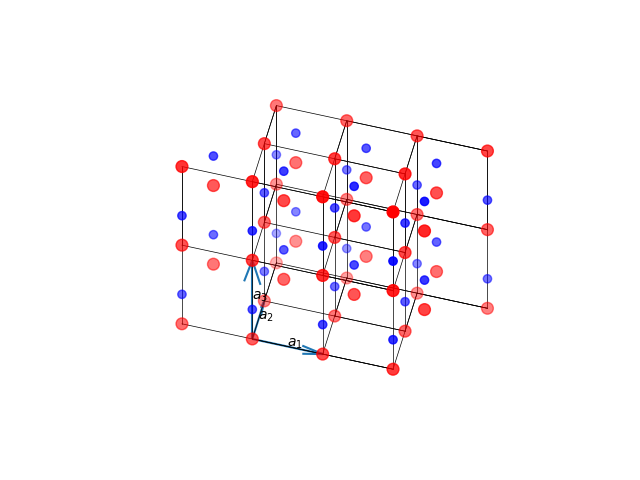

In [16]:
# Inputs
eq = np.isclose
# Lattice vectors (3 vectors of length 3)
a = 1
b = 2
a1 = np.array([1, 0, 0])
a2 = np.array([0, 1, 0])
a3 = np.array([0, 0, 1])
theta = 80*np.pi/180

# Array of basis vectors
basis = np.array([[0,0,0],[0.5,0.5,0],[0.5,0,0.5],[0,0.5,0.5]])
# Colors for each of the basis vectors
blargh = ('r', 'r','b','b')
# Size multiplier for each of the atoms. Default is 1
sizes = (2,2,1,1)
verbose = True


# Gridline type:
# Soft: Lines along cartesian axes. Takes into account nonequal lattice spacing
# LatticeVectors: Lines along the latticevectors (only on lattice points)
GridType = "lattice"

# Limit type:
# individual: Sets the limits as max(nx*a1,ny*a2,nz*a3), so we include nx unitcells in the a1 direction, etc.
# sum: Sets the limits r_min = n_min*[a1 a2 a3] and likewise for n_max
LimType = "dynamic"
Maxs = [2,2,2]
Mins = [0,0,0]

LatticeType = "wurtzite"

#LatticeCreator(a1,a2,a3,basis,colors,sizes,LimType,GridType,Mins,Maxs)
LatticeCreator(Lattice = LatticeType, colors = blargh, sizes = sizes, Maxs = Maxs, verbose=True)


In [10]:
def FindLimits(LimType, a1, a2, a3, Min=[0, 0, 0], Max=[2, 2, 2]):
    """
    Calculates the limits on the coordinates (the plot box), and the limits on
    the basis vector ranges.
    """
    lattice = np.array([a1, a2, a3])
    n_min, n_max = np.array(Min), np.array(Max)
    # For dynamic limits we pass Min and Max as limits of basis vector range
    # and calculate coordinate limit based on basis vector range
    if LimType.lower() in "individual":
        n_min, n_max = np.array(Min), np.array(Max)
        lattice = np.array((a1, a2, a3))
        # Take the max value for each of the cardinal directions, for the
        # three scaled lattice vectors (so x_max is max x value of
        # Max[0] * a1, Max[1] * a2 and Max[2] * a3).
        # this can be done by multiplying the transposed lattice matrix by the
        # n_max vector, then taking max value
        max_vects = lattice.T * n_max
        r_max = np.amax(max_vects, 0)
        # Similar for minimums:
        min_vects = lattice.T * n_min
        r_min = np.amin(min_vects, 0)
    # Different type of coordinate limits. Take r_max as sum(lattice * max)
    # Works well for orthogonal or near-orthogonal lattice vectors
    elif LimType.lower() in "sum":
        lattice = np.array([a1, a2, a3])
        r_max = np.sum(lattice.T * n_max, 0)
        r_min = np.sum(lattice.T * n_min, 0)
    else:
        # We sample all 8 points arising from combinations of min and max:
        # First we get the permutations:
        perms = list(itertools.product([False, True], repeat=3))
        # We create a boolean array of when to multiply by the max and when not to
        maxMult = np.array(perms)
        minMult = np.invert(maxMult)
        # We stack the min and max arrays to have 8 identical rows
        maxstack = np.array(Max * 8).reshape([8, 3])
        minstack = np.array(Min * 8).reshape([8, 3])
        # Each element of the multiplier matrix is made of the appropriate element from max or min. If maxMult[n,m] == False then mult[n,m] = minstack[n,m] and vice versa. This is accomplished by setting the elements of maxstack and minstack equal to 0, when they are not to be multiplied. Then we add the two arrays together.
        maxstack[minMult] = 0
        minstack[maxMult] = 0
        mult = minstack+maxstack
        # The 8 points are thus the matrix product of mult and lattice
        limits = mult @ lattice
        # We take the minimal and maximal values of each column, as the minimum and maximum value for our cartesian axes
        r_min = np.amin(limits,0)
        r_max = np.amax(limits,0)
    # And lastly we return the relevant arrays, with n_min / max -+ some value
    # to allow for "spillage". The value is the maximal value of the Max array.
    # Also, let's make sure n_min / max are arrays of integers. Don't worry,
    # they've already been rounded
    returns = (r_min, r_max, n_min.astype('int') - np.max(Max),
               n_max.astype('int') + np.max(Max))
    return returns

In [4]:
(a1,a2,a3),basis= LatticeChooser("simple monoclinic")
print(FindLimits("individual",a1,a2,a3))
print(FindLimits("sum",a1,a2,a3))
print(FindLimits("Hello",a1,a2,a3))

(array([0., 0., 0.]), array([2.        , 3.        , 3.93923101]), array([-2, -2, -2]), array([4, 4, 4]))
(array([0., 0., 0.]), array([2.        , 3.        , 4.63382372]), array([-2, -2, -2]), array([4, 4, 4]))
(array([0., 0., 0.]), array([2.69459271, 3.        , 3.93923101]), array([-2, -2, -2]), array([4, 4, 4]))
